## 本筆記將實作一些TensorFlow Keras API的建模方式。我們練習的資料集為CIFAR10。


#### 核心概念: 

* 知道如何使用```Model``` API來建模。
* 學習將基本網路結構模組化(例: ```conv block```, ```inception block```)，方便日後將模組拿來重新利用。
* 了解如何實現資料增益(data augmentation)。

---

CIFAR10資料集：https://www.cs.toronto.edu/~kriz/cifar.html

# 本筆記的內容如下：

* [載入圖片至電腦記憶體](#01)
* [將圖片做resize以及normalization](#02)
* [以```Sequential()```逐層疊加出CNN模型](#03)
* [評估模型好壞](#031)
* [以```Model(input,output)```建構出CNN模型](#04)
* [將CNN模型模組化](#05)
* [將MY_CNN網路內的conv block換成inception block](#06)
* [以Data augmentation的方式來對抗overfitting](#07)
* [拿Keras內建的VGG16模型架構來建立模型](#08)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.metrics import classification_report
import json
import pickle

import os

sns.set()
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

## <a id='01'>載入圖片至電腦記憶體 </a>

首先看一下包含資料集的資料夾有什麼內容：

In [2]:
! dir "../datasets/cifar-10-batches-py/"

 磁碟區 C 中的磁碟沒有標籤。
 磁碟區序號:  04C9-755E

 C:\Users\student\Desktop\DL\datasets\cifar-10-batches-py 的目錄

2019/05/24  上午 09:30    <DIR>          .
2019/05/24  上午 09:30    <DIR>          ..
2019/05/24  上午 09:30               213 ._batches.meta
2019/05/24  上午 09:30               213 ._data_batch_1
2019/05/24  上午 09:30               213 ._data_batch_2
2019/05/24  上午 09:30               213 ._data_batch_3
2019/05/24  上午 09:30               213 ._data_batch_4
2019/05/24  上午 09:30               213 ._data_batch_5
2019/05/24  上午 09:30               213 ._labels.txt
2019/05/24  上午 09:30               213 ._readme.html
2019/05/24  上午 09:30               213 ._test_batch
2019/05/24  上午 09:30               158 batches.meta
2019/05/24  上午 09:30        31,035,704 data_batch_1
2019/05/24  上午 09:30        31,035,320 data_batch_2
2019/05/24  上午 09:30        31,035,999 data_batch_3
2019/05/24  上午 09:30        31,035,696 data_batch_4
2019/05/24  上午 09:30        31,035,623 data_batch_5
2019/05/24  上午 09:30    

data_batch_1, data_batch_2,..data_batch_5以及test_batch是以binary的方式儲存在硬碟裡。以下我們寫幾個函數，用以載入這些binary格式的圖檔至電腦內的記憶體中，並且將圖的以矩陣的方式儲存。這些圖矩陣的shape為(Number of figures,Width,Height,Channel)。

In [3]:
def load_batch(fpath):
    """This function extract a batch of CIFAR10 data
       from the chosen binary file.
       This function is a simplified version of
       https://github.com/keras-team/keras/blob/master/keras/datasets/cifar.py
    """
    with open(fpath, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        # Keys are in the "byte" format. Let's decode them into utf8 strings.
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    data = d['data']
    labels = d['labels']
    data = data.reshape(data.shape[0], 3, 32, 32)
    data = data.transpose(0,2,3,1)
    return data, labels


def load_data(path):
    '''
    載入以binary方式儲存的影像至電腦內記憶體。
    '''
    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 32,32,3), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_') + str(i)
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000:i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000:i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    return (x_train, y_train), (np.array(x_test), np.array(y_test,dtype="uint8"))

In [4]:
(x_train, y_train), (x_test, y_test) = load_data('../datasets/cifar-10-batches-py')

In [5]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


以上，我們得到了x_train, x_test, y_train,y_test四個放置圖片的矩陣，其shape均為(Number of figures,Width,Height,Channel)。

接著，我們抽出幾張圖來看，稍微了解一下這些資料大概的樣貌：

In [6]:
with open("../datasets/cifar-10-batches-py/labels.txt") as reader:
    fig_labels = reader.read()
fig_labels = fig_labels.split("\n")[:-1]

In [7]:
idx_to_label={}
for idx,fig_labels in enumerate(fig_labels):
        idx_to_label[idx]=fig_labels

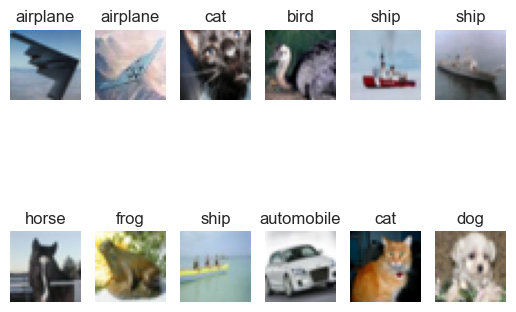

In [8]:
#隨機抽取12張圖來看一下
num_figures_display=12
fig_indexes=np.random.choice(x_train.shape[0],num_figures_display)

fig,axes=plt.subplots(2,6)
for fig_idx,axis in zip(fig_indexes,axes.reshape(-1) ):
    axis.axis('off')
    axis.imshow(x_train[fig_idx])
    axis.set_title(idx_to_label[ y_train[fig_idx] ])

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='02'> 將圖片做resize以及normalization </a>

In [9]:
import cv2
from tensorflow.keras.utils import to_categorical

# 做normalization。
# 一個簡單的方式，是將x直接除以255，使得x內的所有值均分佈於[0,1]之間。
x_train = x_train / 255.
x_test = x_test / 255.

# 調整x_train每張圖的大小從(32,32)乘以三倍，變成(96,96)。
x_train_resized = np.zeros((50000, 96, 96, 3), dtype=np.float32)
for idx,img in enumerate(x_train):
    if idx%10000==0:
        print(idx)
    x_train_resized[idx,:] = cv2.resize(img, None, fx=3, fy=3, interpolation = cv2.INTER_AREA)

# 調整x_test每張圖的大小從(32,32)乘以三倍，變成(96,96)。
x_test_resized = np.zeros((10000, 96, 96, 3),dtype=np.float32)
for idx,img in enumerate(x_test):
    if idx%1000==0:
        print(idx)
    x_test_resized[idx,:] = cv2.resize(img, None, fx=3, fy=3, interpolation = cv2.INTER_AREA)

# 將y轉換成為one hot的形式
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

0
10000
20000
30000
40000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='03'> 以```Sequential()```逐層疊加出CNN模型 </a>

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation


class MY_CNN:
    '''建立一個CNN模型'''
    def __init__(self, in_shape, out_classes, do_last_activation=True):
        
        self.in_shape = in_shape
        self.out_classes = out_classes
        self.do_last_activation = do_last_activation
        
    def build_model(self):
        '''以Sequential()逐層疊加模型。'''
        
        model = Sequential()
        # conv block 1
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu",
                                     input_shape=self.in_shape) )
        model.add(Conv2D(32, (3, 3), activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # conv block 2
        model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
        model.add(Conv2D(64, (3, 3), activation="relu") )
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # dense block
        model.add(Flatten())
        model.add(Dense(512, activation="relu") )
        model.add(Dropout(0.5))
        model.add(Dense(self.out_classes))
        
        if self.do_last_activation:
            model.add(Activation('softmax'))
        return model

In [ ]:
# 取得模型
model=MY_CNN(in_shape=(32,32,3), out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
# 訓練模型
history=model.fit(x=x_train, y=y_train_one_hot, validation_data=(x_test, y_test_one_hot),
                  epochs=20, batch_size=128)
#畫出訓練過程
plt.plot(history.history['accuracy'], ms=5, marker='o', label='accuracy')
plt.plot(history.history['val_accuracy'], ms=5, marker='o', label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

# <a id='031'> 評估模型好壞 </a>

看metrics，如f1, precision, recall的表現:

In [ ]:
from sklearn.metrics import classification_report

predY = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, predY))

看accuracy的表現:

In [ ]:
idx_to_label

In [ ]:
# 練習於此 
# 提示：使用model.predict(...)或model.evaluate(...)
#

隨機抽取12張圖來看一下:

In [ ]:
num_figures_display = 12
fig_indexes = np.random.choice(x_test.shape[0],
                               num_figures_display)

#建立 2X6 子圖
fig, axes = plt.subplots(2, 6, figsize=(10,5))
for fig_idx, axis in zip(fig_indexes, axes.reshape(-1) ):
    axis.axis('off')
    axis.imshow(x_test[fig_idx])              # 畫圖
    label = idx_to_label[ y_test[fig_idx] ]     # 取得真實標籤
    pred_label = idx_to_label[ predY[fig_idx] ] # 取得預測標籤
    
    # 畫出真實標籤和預測標籤
    if label != pred_label:
        axis.text(16,-3, pred_label, fontsize='large', color='r', ha ='center')
    else:
        axis.text(16,-3, pred_label, fontsize='large', color='b', ha ='center')
    axis.set_title(label+"\n")

## <a id='04'>以```Model(input,output)```建構出CNN模型 </a>

* Path_A: `(BS, 32, 32, 3)` -> MY_CNN(last_activation=False) -> `(BS, 10)`

* Path_B: `(BS, 32, 32, 3)` -> MaxPool2d -> `(BS, 16, 16, 3)` -> Flatten -> `(BS, 16*16*3)` -> Dense(10) -> `(BS, 10)`

* (Path_A [concat] Path_B) -> `(BS, 20)` -> Dense(10)+softmax -> `(BS, 10)`

In [11]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

In [ ]:
# images = x_test[:8, ...]
# images.shape

images = Input((32, 32, 3))
# images.shape

my_cnn_model = MY_CNN(
    in_shape=(32,32,3),
    out_classes=10,
    do_last_activation=False,
).build_model()

# my_cnn_model(images).shape

my_dense_model = Sequential()
my_dense_model.add(MaxPooling2D(input_shape=(32,32,3)))
my_dense_model.add(Flatten())
my_dense_model.add(Dense(units=10))

# my_dense_model(images).shape

out1 = my_cnn_model(images)
out2 = my_dense_model(images)

out = tf.concat([out1, out2], axis=-1)
out = Dense(units=10, activation='softmax')(out)

In [ ]:
model = Model(images, out)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
# 訓練模型
history=model.fit(x=x_train, y=y_train_one_hot, validation_data=(x_test, y_test_one_hot),
                  epochs=5, batch_size=128)
#畫出訓練過程
plt.plot(history.history['accuracy'], ms=5, marker='o', label='accuracy')
plt.plot(history.history['val_accuracy'], ms=5, marker='o', label='val accuracy')
plt.legend()
plt.show()

---

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,Input


class MY_CNN(object):
    """建立一個CNN模型。
    """

    def __init__(self,in_shape,out_classes):

        self.in_shape = in_shape
        self.out_classes = out_classes
        
    def build_model(self):
        """以Sequential()逐層疊加模型。
        """
        image = Input(self.in_shape)
        # conv block 1
        conv1 = Conv2D(32, (3, 3), padding="same",activation="relu")
        conv2 = Conv2D(32, (3, 3), activation="relu")
        pool1 = MaxPooling2D(pool_size=(2, 2))
        dropout = Dropout(0.25)
        
        x = dropout(
            pool1(
                conv2(
                    conv1(image))))
        # conv block 2
        conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")
        conv2 = Conv2D(64, (3, 3), activation="relu")
        pool1 = MaxPooling2D(pool_size=(2, 2))
        dropout = Dropout(0.25)
        x = dropout(
            pool1(
                conv2(
                    conv1(x))))
        # dense block
        x = Dense(self.out_classes,activation="softmax")(
            Dropout(0.5)(
                Dense(512,activation="relu")(
                    Flatten()(x))))
        model = Model(image,x)
        return model

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='05'> 將CNN模型模組化</a>

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,Input


class MY_CNN(object):
    """建立一個CNN模型。
    """
    
    def __init__(self,in_shape,out_classes):
        
        self.in_shape=in_shape
        self.out_classes=out_classes

    def conv_block(self,n,x):
        """建構convolution block。
        """
        conv1 = Conv2D(n, (3, 3), padding="same",activation="relu")
        conv2 = Conv2D(n, (3, 3), activation="relu")
        pool1 = MaxPooling2D(pool_size=(2, 2))
        dropout = Dropout(0.25)
        x = dropout(
            pool1(
                conv2(
                    conv1(x))))
        return x

    def build_model(self):
        """以Model(input,output)的方式建立模型。
        """
        
        image = Input(self.in_shape) # input image
        x = self.conv_block(32,image)  # conv block 1
        x = self.conv_block(64,x)      # conv block 2
        
        # dense block
        x = Dense(self.out_classes, activation="softmax")(
            Dropout(0.5)(
                Dense(512,activation="relu")(
                    Flatten()(x))))
        # Build the model out of the graph, given tne input/output tensor
        model = Model(image,x)
        return model

In [ ]:
# 取得模型
model = MY_CNN(in_shape=(32,32,3), out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
# 訓練模型
history = model.fit(x=x_train, y=y_train_one_hot, validation_data=(x_test,y_test_one_hot),
                    epochs=20, batch_size=128)
#畫出訓練過程
plt.plot(history.history['acc'], ms=5, marker='o', label='accuracy')
plt.plot(history.history['val_acc'], ms=5, marker='o', label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

以下我們嘗試將一個cnn block換成inception block (GoogleNet內部的主要架構)，看訓練模型會有什麼樣的結果。

## <a id='06'>將MY_CNN內的一個conv block換成inception block</a>

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, Input, Concatenate


class MY_CNN_INCEPT_BLOCK(object):
    """建立一個CNN模型
    """

    def __init__(self,in_shape,out_classes):
        
        self.in_shape = in_shape
        self.out_classes = out_classes

    def conv_block(self,n,x):
        
        conv1 = Conv2D(n, (3, 3), padding="same",activation="relu")
        conv2 = Conv2D(n, (3, 3),activation="relu")
        pool1 = MaxPooling2D(pool_size=(2, 2))
        dropout = Dropout(0.25)
        x = dropout(
            pool1(
                conv2(
                    conv1(x))))
        return x
    
    def inception_block(self, x, n1_1, n2_1, n2_3, n3_1, n3_5, n4_1):

        path1_conv_1 = Conv2D(n1_1, (1,1), activation="relu")
        path2_conv_1 = Conv2D(n2_1, (1,1), activation="relu")
        path2_conv_3 = Conv2D(n2_3, (3,3), padding='same', activation="relu")
        path3_conv_1 = Conv2D(n3_1, (1,1), activation="relu")
        path3_conv_5 = Conv2D(n3_5, (5,5), padding='same', activation="relu")
        path4_pool_3 = MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding='same')
        path4_conv_1 = Conv2D(n4_1, (1,1), activation="relu")

        path1 = path1_conv_1(x)
        path2 = path2_conv_3(path2_conv_1(x))
        path3 = path3_conv_5(path3_conv_1(x))
        path4 = path4_conv_1(path4_pool_3(x))
        return Concatenate(axis=-1)([path1,path2,path3,path4])

    def build_model(self):
        """以Model(input,output)的方式建立模型。
        """
        
        image = Input(self.in_shape)  # input image
        x = self.conv_block(32, image)  # conv block
        # x = self.conv_block(64,x)      # conv block 2
        x = self.inception_block(x, 8, 12, 16, 2, 4, 4)  # inception block
        # entering into the dense block
        x = Dense(self.out_classes, activation="softmax")(
            Dropout(0.5)(
                Dense(512, activation="relu")(
                    Flatten()(x))))
        # Build the model out of the graph, given tne input/output tensor
        model = Model(image, x)
        return model

In [ ]:
# 取得模型
model = MY_CNN_INCEPT_BLOCK(in_shape=(32,32,3),out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
# 訓練模型
history = model.fit(x=x_train, y=y_train_one_hot, validation_data=(x_test, y_test_one_hot),
                  epochs=20, batch_size=128)
#畫出訓練過程
plt.plot(history.history['accuracy'], ms=5, marker='o', label='accuracy')
plt.plot(history.history['val_accuracy'], ms=5, marker='o', label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

可見此模型有overfitting的現象。以下我們試著以data augmentation 來對抗overfitting：

---

## <a id='07'>以Data augmentation的方式來對抗overfitting </a>

以下我們採用```imgaug``` 這個套件來做資料增益。

https://github.com/aleju/imgaug

In [ ]:
from imgaug import augmenters as iaa
from dataloader import DataSequenceFromNumpyArray, input_fn

In [ ]:
# 取得一連串的增益方法 (a sequence of augmenters)
sometimes = lambda augmenter: iaa.Sometimes(0.7, augmenter)
imgaug_seq = [sometimes(iaa.Affine(rotate=(-30,30), cval=0., mode="edge", name="rotate")),
              iaa.Noop()]
imgaug_seq = iaa.Sequential(imgaug_seq)

# 取得批次資料產生器。並且將增益方法套用在批次資料上.
train_gen = DataSequenceFromNumpyArray(x_train, y_train_one_hot, batch_size=128, 
                                       imgaug=True, imgaug_seq=imgaug_seq)
val_gen = DataSequenceFromNumpyArray(x_test, y_test_one_hot, batch_size=128, 
                                     imgaug=True, imgaug_seq=imgaug_seq)

# 將批次資料產生器包成 TF dataset
img_shape = (32, 32, 3)
label_shape = (None, 10)

ds_train = input_fn(train_gen, img_shape=img_shape, label_shape=label_shape,
                    auto_prefetching=False, img_dtype=np.float32,
                    label_dtype=tf.int32)
ds_val = input_fn(val_gen, img_shape=img_shape, label_shape=label_shape,
                  auto_prefetching=False, img_dtype=np.float32,
                  label_dtype=tf.int32)

In [ ]:
# 取得模型
model = MY_CNN_INCEPT_BLOCK(in_shape=img_shape, out_classes=10).build_model()
# 編譯模型：給定模型目標和訓練方式。
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen))

# 畫出訓練過程
plt.plot(history.history['acc'], ms=5, marker='o', label='accuracy')
plt.plot(history.history['val_acc'], ms=5, marker='o', label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='08'>拿Keras內建的VGG16模型架構來建立模型</a>

```tensorflow.keras.applications```裡面內建了一些常見的架構，如VGG, GoogleNet, ResNet等。以下我們嘗試來使用VGG16建立模型：

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD

In [16]:
# # 取得內建的VGG模型 (去掉後層分類器的部分)
# model=VGG16(include_top=True,
#             input_shape=(96,96,3))

In [17]:
# 取得內建的VGG模型 (去掉後層分類器的部分)
model=VGG16(include_top=False,
            input_shape=(96,96,3))

In [18]:

# 添加後層分類器至內建VGG模型
last = model.output
x = Flatten()(last)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(10, activation='softmax')(x)
# 組合模型
model = Model(model.input, preds)
# 編譯模型，告知模型訓練方式
model.compile(loss="categorical_crossentropy",
              optimizer=SGD(learning_rate=1e-2, 
                            decay=1e-6,
                            momentum=0.9,
                            nesterov=True),
              metrics=["accuracy"])

In [26]:
images = x_train_resized[:2, ...]
images.shape

(2, 96, 96, 3)

In [27]:
model(images).shape

TensorShape([2, 10])

In [29]:
x_train_resized.shape

(50000, 96, 96, 3)

In [33]:
rec = model.fit(x=x_train_resized[:1000, ...],
                y=y_train_one_hot[:1000, ...],
                # validation_data=(x_test_resized,
                #                  y_test_one_hot),
                epochs=2,
                batch_size=1)

Epoch 1/2
1000/1000 [==============================] - 45s 45ms/step - loss: 2.3226 - accuracy: 0.0930
Epoch 2/2
1000/1000 [==============================] - 45s 45ms/step - loss: 2.3233 - accuracy: 0.1040


In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [ ]:
# # 畫出訓練過程
# plt.plot(rec.history['acc'], ms=5, marker='o', label='accuracy')
# plt.plot(rec.history['val_acc'], ms=5, marker='o', label='val accuracy')
# plt.legend()
# plt.show()

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)